## Load Dependencies

In [6]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.nn import LSTM
from torch.nn import Parameter
from torch.nn import MSELoss, L1Loss, SmoothL1Loss, CrossEntropyLoss
from scipy.special import huber
#from torch.autograd import Variable


import pandas as pd
import numpy as np
import math
import json
import re
from nltk.tokenize import word_tokenize

from collections import Iterable
from tqdm import tqdm

import matplotlib.pyplot as plt


sys.path.insert(0, '/Users/sidvash/facts_lab/factslab-python/factslab/')
from utility import load_glove_embedding
from datastructures import ConstituencyTree
from pytorch.childsumtreelstm import *
#from pytorch.rnnregression import RNNRegressionTrainer
from pytorch.rnnregression import RNNRegression


torch.manual_seed(1)

## Load the data from MTurK

In [2]:
#Data locations:
turk_output = "/Users/sidvash/facts_lab/factslab-protocols-eventtype/" 
turk_output += "Temporal_relations/testing_HIT/Batch_3246275_batch_results.csv"

embed_path = '/Users/sidvash/kaggle/'

In [3]:
def filter_sentence(s):
    '''
    Filter out html <span> tags from a sentence 
    '''
    
    s = re.sub(r'\<span class\=\\"predicate\\">', r'', s)
    
    s = re.sub(r'\<\/span\>', r' ', s)
    
    s = re.sub(r'  ', r'', s) #remove extra spaces

    return s

def extract_dataframe(data):
    '''
    Input: Pandas csv dataframe obtained from MTurk
    
    Output: Pandas dataframe levelled by (User x Sentenced_ID)
    '''
    data["dicts"] = data["Input_var_arrays"].map(lambda x: json.loads(x))
    global_list = []
    
    for row in data.itertuples():
        for idx, local_dict in enumerate(row.dicts):
            temp_dict = local_dict.copy()
            var_instant = "Answer_instantaneous" + str(idx+1)
            var_instant_c =  "Answer_confidence_instantaneous" + str(idx+1)
            var_start = "Answer_startpt" + str(idx+1)
            var_start_c = "Answer_confidence_startpoint" + str(idx+1)
            var_end = "Answer_endpt" + str(idx+1)
            var_end_c = "Answer_confidence_endpoint" + str(idx+1)
            var_duration = "Answer_duration" + str(idx+1)
            var_duration_c = "Answer_confidence_duration" + str(idx+1)

            temp_dict["is_instant"] = getattr(row, var_instant)
            temp_dict["conf_instant"] = getattr(row, var_instant_c)
            temp_dict["has_start"] = getattr(row, var_start)
            temp_dict["conf_start"] = getattr(row, var_start_c)
            temp_dict["has_end"] = getattr(row, var_end)
            temp_dict["conf_end"] = getattr(row, var_end_c)
            temp_dict["duration"] = getattr(row, var_duration)
            temp_dict["conf_duration"] = getattr(row, var_duration_c)
            temp_dict["worker_id"] = row.WorkerId
            temp_dict["hit_id"] = row.HITId

            global_list.append(temp_dict)
            
    return pd.DataFrame(global_list)

In [4]:
data = pd.read_csv(turk_output)
data.columns = [c.replace('.', '_') for c in data.columns]
#data.head()

pilot_data = extract_dataframe(data)

#Re-arrange the order 
cols = list(pilot_data.columns)
pilot_data = pilot_data[pilot_data.columns[::-1]]
#pilot_data = pilot_data[pilot_data.columns[::-1]].drop('sentence', axis=1)

#pilot_data.replace('na',np.NaN, inplace=True)
pilot_data.head
pilot_data['sent_token'] = pilot_data['sentence_id'] + "_" +\
                            pilot_data['pred_token'].map(lambda x: str(x))
#pilot_data.head()

In [5]:
def duration_to_int(dur):
    '''
    Map string durations to an integer
    '''
    
    try:
        return int(dur)
        
    except:
        return 10
        

In [6]:
## Data features
pilot_data['filter_sent'] = pilot_data['sentence'].map(lambda x: [filter_sentence(x).split(" ")])
pilot_data['pred_token_int'] = pilot_data['sent_token'].map(lambda x: int(x.split("_")[-1]) + 1)
pilot_data['pred_tokens'] = pilot_data.apply(lambda row: [[row.pred_token_int]], axis=1)



pilot_data['duration_int'] = pilot_data.apply(lambda row: duration_to_int(row.duration), axis=1)
#Convert objects to numerics

X_data = pilot_data[['filter_sent','pred_token_int', 'pred_tokens']]
y_data = pilot_data[['duration_int']]


## View Data

In [7]:
X_data.head()

,filter_sent,pred_token_int,pred_tokens
0,"[[&lsqb;, an, error, occurred, while, processi...",4,[[4]]
1,"[[&lsqb;, an, error, occurred, while, processi...",6,[[6]]
2,"[[Adolf, Hitler, even, held, an, exhibition, o...",4,[[4]]
3,"[[Adolf, Hitler, even, held, an, exhibition, o...",16,[[16]]
4,"[[The, central, question, behind, the, palace,...",21,[[21]]


In [8]:
y_data.head()

,duration_int
0,10
1,8
2,5
3,4
4,5


In [9]:
X = X_data.filter_sent.values
idxs = X_data.pred_tokens.values
y = list(list(y_data.values))

data = list(zip(X, idxs, y))
##Check sample values
# print(X[0])
# print(idxs[0])
# print(y[0])

In [10]:
print(data[0])

([['&lsqb;', 'an', 'error', 'occurred', 'while', 'processing', 'this', 'directive', '&rsqb;']], [[4]], array([10]))


### Model Class

In [11]:
## import from factslab

## Load embeddings

#### Glove embeddings and Word_to_ix dict

In [12]:
vocab_set = set()
for [sent] in X:
    for word in sent:
        if word not in vocab_set:
            vocab_set.add(word) 
print("Vocab size: {}".format(len(vocab_set)))

vocab = list(vocab_set)

Vocab size: 1275


In [13]:
glove_embeddings = load_glove_embedding(embed_path + 'glove.42B.300d', vocab)

## Instantiate the RNN-Regression model

In [14]:
out_size = len(np.unique(y))

model = RNNRegression(embeddings = glove_embeddings, rnn_classes = LSTM, 
                      rnn_hidden_sizes = 300, num_rnn_layers=1, bidirectional=True, attention=False,
                      regression_hidden_sizes = [32, 1], output_size = out_size )

## Fit the model and backpropagate

In [15]:
optimizer_class=torch.optim.Adam
optimizer = optimizer_class(model.parameters())
#optimizer

In [16]:
total_obs = len(data)
global_losses = []

for epoch in range(10):
    epoch_losses = []
    
    for i, (words, [idx], target) in tqdm(enumerate(data)):
        optimizer.zero_grad()
        
        if not isinstance(target, list):
            target = [target]
        
        predicts = model(words, idxs=idx)
        actuals = [torch.from_numpy(arr).long().view(1) for arr in target]

        loss_fn = CrossEntropyLoss()

        word_loss = []
        
        for predicted, actual in list(zip(predicts, actuals)):
            word_loss.append(loss_fn(predicted, actual))

        sent_loss = sum(word_loss)
        
        epoch_losses.append(sent_loss.item())
        global_losses.append(sent_loss.item())
        
        sent_loss.backward()
        optimizer.step()
        
    print("Epoch {} completed. Mean Cross Entropy Loss for the Epoch: {}".format((epoch+1), np.mean(epoch_losses)))

1000it [01:01, 16.21it/s]
3it [00:00, 27.69it/s]

Epoch 1 completed. Mean Cross Entropy Loss for the Epoch: 2.333160578250885


1000it [00:59, 16.72it/s]
3it [00:00, 26.65it/s]

Epoch 2 completed. Mean Cross Entropy Loss for the Epoch: 2.3205303971767424


1000it [00:59, 16.70it/s]
3it [00:00, 28.34it/s]

Epoch 3 completed. Mean Cross Entropy Loss for the Epoch: 2.309364683628082


1000it [01:00, 16.60it/s]
3it [00:00, 27.24it/s]

Epoch 4 completed. Mean Cross Entropy Loss for the Epoch: 2.2994295830726625


1000it [01:00, 16.52it/s]
3it [00:00, 25.74it/s]

Epoch 5 completed. Mean Cross Entropy Loss for the Epoch: 2.2904805772304533


1000it [01:00, 16.43it/s]
3it [00:00, 28.94it/s]

Epoch 6 completed. Mean Cross Entropy Loss for the Epoch: 2.282180203318596


1000it [01:01, 16.15it/s]
3it [00:00, 29.78it/s]

Epoch 7 completed. Mean Cross Entropy Loss for the Epoch: 2.2744658448696136


1000it [01:01, 16.28it/s]
3it [00:00, 28.23it/s]

Epoch 8 completed. Mean Cross Entropy Loss for the Epoch: 2.2673090735673904


1000it [01:02, 16.01it/s]
4it [00:00, 27.30it/s]

Epoch 9 completed. Mean Cross Entropy Loss for the Epoch: 2.2606502562761306


1000it [01:01, 16.31it/s]

Epoch 10 completed. Mean Cross Entropy Loss for the Epoch: 2.254392975687981


## Plotting Loss

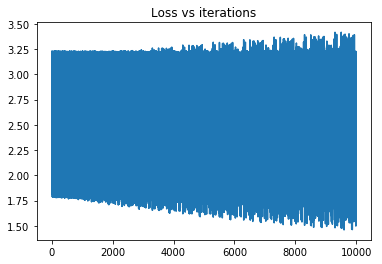

In [32]:
plt.plot(global_losses)
plt.title("Loss vs iterations")
plt.show()

# plt.plot(epoch_losses)
# plt.title("Loss vs Epochs")
# plt.show()

## Prediction

In [33]:
data_idx = 0

words = data[data_idx][0]
[idx] = data[data_idx][1]
print("Predicted value")
out = model(words, idxs = idx)
out

Predicted value


[tensor([[-2.7797, -3.2687, -2.0943, -1.7058, -3.1316, -3.5621, -3.2310,
          -3.4613, -1.4799, -3.4098, -1.6530]])]

In [34]:
label = np.argmax(out[0].detach().numpy())
print("Predicted label: {}".format(label))

Predicted label: 8


In [35]:
print("Actual label: {}".format(data[data_idx][2][0]))

Actual label: 10


## Accuracy

In [28]:
count = 0
correct = 0
for i, (words, [idx], target) in tqdm(enumerate(data)):
    
    
    out = model(words, idxs=idx)
    pred_label = np.argmax(out[0].detach().numpy())
    actuals = target[0]
    
    if pred_label == actuals:
        correct += 1
        
    count +=1
    
print("Accuracy: {}".format((correct/count)*100))
    
    

1000it [00:09, 109.75it/s]

Accuracy: 12.5


## Rough Work

In [20]:
# embeddings = torch.nn.Embedding(1275, 300)

# indices = [[1], [2], [5], [45]]
# indices = torch.tensor(indices, dtype=torch.long)
# print(indices.type())
# indices.requires_grad